# Aleatoric uncertainty estimation in movie-based traffic forecasting

This notebook contains the code to reproduce our figures on aleatoric uncertainty quantification methods

In [1]:
import torch
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import json
import time
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

/Users/ninawiedemann/miniconda3/envs/gis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
method_dict = {"attenuation": "Loss attenuation",
              "patch": "Patch-based",
              "tta": "Test time augmentation",
               "patchtta": "Patch + TTA",
              "staticpatch": "Patches (with static map)",
              "trivial": "Trivial"}

In [36]:
main_results = ['patch_antwerp_30', 'patch_bangkok_30', 'attenuation_antwerp_0', 'attenuation_bangkok_0',
              'patchtta_antwerp_30', 'patchtta_bangkok_30', 'tta_antwerp_0', 'tta_bangkok_0']

In [6]:
base = "../output_std/unc_final"

## Model comparison

In [37]:
summary = []
for folder in main_results:
    folder = os.path.join(folder, "speed")
    
    res_df = pd.read_csv(os.path.join(base, folder, "correlation_df.csv"))
    np_calibration = np.load(os.path.join(base, folder, "calibration.npy"))
    ence_scores = np.load(os.path.join(base, folder, "ence_scores.npy"))
    coverage = np.load(os.path.join(base, folder, "coverage.npy"))
    pi_width = np.load(os.path.join(base, folder, "pi_width.npy"))

    summary.append({"Method": method_dict[folder.split("_")[0]], 
                    "City": folder.split("_")[-2],
                    "Runtime (per sample)": np.mean(res_df["runtime"]), 
                   "MSE": np.mean(res_df["mse"]),
                   "Calibration (Pearson r)": np.nanmean(np_calibration),
                    "ENCE": np.mean(ence_scores),
                   "PI width": np.mean(pi_width)
                   } 
                  )
summary = pd.DataFrame(summary)
antwerp = summary[summary["City"] == "antwerp"]
bangkok = summary[summary["City"] == "bangkok"]
final = pd.concat([antwerp.drop("City", axis=1).set_index("Method"), bangkok.drop("City", axis=1).set_index("Method")], keys=["Antwerp", "Bangkok"], axis=1)
final = final.sort_values(("Antwerp", "Calibration (Pearson r)"))
final

Antwerp             \
                       Runtime (per sample)        MSE   
Method                                                   
Loss attenuation                   0.200514  43.561470   
Test time augmentation             4.258813  41.570487   
Patch-based                        4.972606  40.707612   
Patch + TTA                       40.760403  40.892876   

                                                                     \
                       Calibration (Pearson r)       ENCE  PI width   
Method                                                                
Loss attenuation                      0.245292  11.862859  7.581267   
Test time augmentation                0.427504  16.389545  7.159764   
Patch-based                           0.691823  52.171315  4.262950   
Patch + TTA                           0.786902   2.943982  3.432409   

                                    Bangkok             \
                       Runtime (per sample)        MSE   
Method                                                   
Loss attenuation                   0.215115  30.708617   
Test time augmentation             4.514387  30.396093   
Patch-based                        5.125725  29.181550   
Patch + TTA                       40.300184  29.484899   

                                                                     
                       Calibration (Pearson r)       ENCE  PI width  
Method                                                               
Loss attenuation                      0.249323  10.589801  4.925429  
Test time augmentation                0.406062  15.651074  5.261065  
Patch-based                           0.675931  42.013312  3.911848  
Patch + TTA                           0.795583   2.427878  3.212098

## Temporal uncertainty: Prediction horizon

In [39]:
from matplotlib.lines import Line2D
xaxis = [5, 10, 15, 30, 45, 60]
matplotlib.rcParams.update({'font.size': 20})

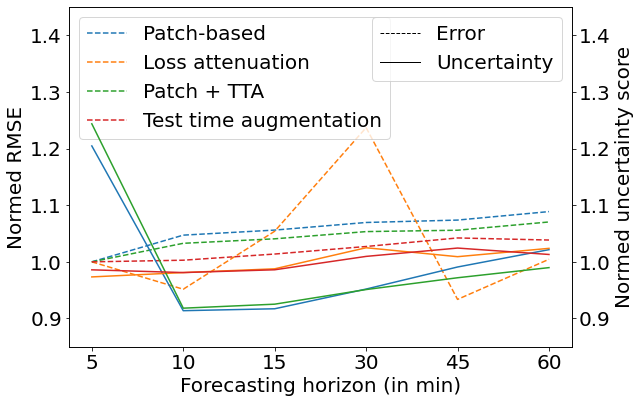

In [40]:
plt.figure(figsize=(9.3,6))
ax = plt.subplot(111)
ax2 = ax.twinx()
for folder in main_results:
    # load
    if folder[0] == "." or "static" in folder or "bangkok" in folder or "20" in folder or "40" in folder: 
        continue
    folder_speed = os.path.join(base, folder, "speed")
    res_df = pd.read_csv(os.path.join(folder_speed, "correlation_df.csv"))
    
    # get unc and err for the 6 steps
    unc_steps = res_df[["mean_unc_"+str(i) for i in range(6)]].mean()
    err_steps = res_df[["mean_rmse_"+str(i) for i in range(6)]].mean()
    # norm
    unc_steps = unc_steps / np.mean(unc_steps)
    err_steps = err_steps / np.mean(err_steps[0])
    
    # get label and plot
    method = method_dict[folder.split("_")[0]] 
    ax.plot(err_steps.values, "--", label=method)
    ax2.plot(unc_steps.values, label=method)
    
plt.xticks(np.arange(6), xaxis)
ax.set_xlabel("Forecasting horizon (in min)")
ax.set_ylabel("Normed RMSE")
ax2.set_ylabel("Normed uncertainty score")
ax.set_ylim(0.85, 1.45)
ax2.set_ylim(0.85, 1.45)
ax.legend(loc="upper left")

custom_lines = [Line2D([0], [0], color="black", linestyle="--", lw=1),
                Line2D([0], [0], color="black", lw=1)]
ax2.legend(custom_lines, ['Error', 'Uncertainty'])
plt.tight_layout()
# plt.savefig("time_horizon.pdf")
plt.show()

## Temporal uncertainty: daytime

In [24]:
path = os.path.join(base, "one_day_patch_bangkok_30", "speed")

In [25]:
res_df = pd.read_csv(os.path.join(path, "correlation_df.csv"))

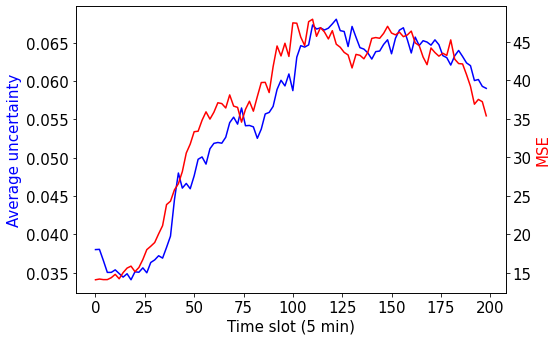

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(res_df["time"], res_df["mean_unc_5"], c="blue")
ax.set_ylabel("Average uncertainty", c="blue")
ax.set_xlabel("Time slot (5 min)")
ax2 = ax.twinx()
ax2.plot(res_df["time"], res_df["mse"], c="red")
ax2.set_ylabel("MSE", c="red")
plt.tight_layout()
# plt.savefig("daytime_oneday.pdf")
plt.show()

## Ablation study: coverage

In [42]:
path = os.path.join(base, "patchtta_antwerp_30", "speed")
cov = np.load(os.path.join(path, "coverage.npy"))

In [43]:
alpha, beta, loc, scale = stats.beta.fit(cov.flatten())

/Users/ninawiedemann/miniconda3/envs/gis/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/ninawiedemann/miniconda3/envs/gis/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


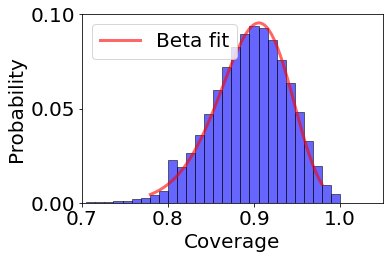

In [44]:
a, b = (alpha, beta)
x = np.linspace(stats.beta.ppf(0.01, a, b, loc=loc, scale=scale),
               stats.beta.ppf(0.99, a, b, loc=loc, scale=scale), 100)
plt.plot(x, stats.beta.pdf(x, a, b, loc=loc, scale=scale)/100,
          'red', lw=3, alpha=0.6, label='Beta fit')
sns.histplot(cov.flatten(), bins=57, stat="probability", color="blue", alpha=0.6)
plt.xlim(0.7, 1.05)
plt.xlabel("Coverage")
plt.legend()
plt.tight_layout()
# plt.savefig("coverage_hist.pdf")
plt.show()

## Ablation study: Prediction intervals

In [45]:
samples = np.load(os.path.join(base, "results_for_pi_plot.npy"))

In [46]:
quantiles = np.load(os.path.join(base, "patchtta_bangkok_30", "speed_quantiles.npy"))

In [47]:
# get cell where all are not null
np.where(np.all(samples[:, 0] > 0, axis=(0)))

(array([292, 293]), array([252, 252]), array([2, 2]))

In [48]:
x, y, c = 292, 252, 2

In [50]:
# compute the lower and upper bound of the intervals
def get_pred_interval(pred, quantiles):
    return np.stack(((pred[:, 0, ...] - pred[:, 1, ...] * quantiles),
                        (pred[:, 0, ...] + pred[:, 1, ...] * quantiles)), axis=1)
intervals = get_pred_interval(samples[:, 1:], quantiles)

In [51]:
# the error is just the difference between prediction and the lower / upper bound of the interval
yerror = np.abs(intervals[:, 1, x, y, c] - samples[:, 1, x, y, c])
gt = samples[:, 0, x, y, c]
pred = samples[:, 1, x, y, c]
unc = samples[:, 2, x, y, c]

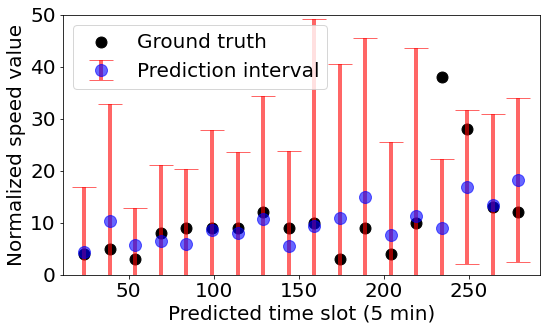

In [52]:
plt.figure(figsize=(8,5))
x_min = np.arange(0, 264, 15) + 24
plt.scatter(x_min, gt, c="black", label="Ground truth", s=120)
plt.errorbar(x_min, pred, yerr = yerror, fmt = 'o',color = 'blue', 
            ecolor = 'red', elinewidth = 4, alpha=0.6, capsize=12, markersize=12, label="Prediction interval")
plt.ylim(0, 50)
plt.xlabel("Predicted time slot (5 min)")
plt.ylabel("Normalized speed value")
plt.legend()
plt.tight_layout()
# plt.savefig("prediction_intervals.pdf")
plt.show()

## Ablation study: Patch stride

In [9]:
# logged manually
mean_patches_per_cell = {
    "mean":{
        20: 17.5,
        30: 9,
        40: 5.1
    },
    "median":{
        20: 20,
        30: 9,
        40: 6
    }
}

In [12]:
summary = []
for folder in ["patch_antwerp_20", "patch_antwerp_30", "patch_antwerp_40"]:
    folder = os.path.join(folder, "speed")
    
    res_df = pd.read_csv(os.path.join(base, folder, "correlation_df.csv"))
    np_calibration = np.load(os.path.join(base, folder, "calibration.npy"))
    ence_scores = np.load(os.path.join(base, folder, "ence_scores.npy"))
    coverage = np.load(os.path.join(base, folder, "coverage.npy"))
    pi_width = np.load(os.path.join(base, folder, "pi_width.npy"))
    
    stride = folder.split("_")[-1][:-6]

    summary.append({"Patch stride": stride,
                    "Mean patches per cell": mean_patches_per_cell["mean"][int(stride)],
                    "Runtime (per sample)": np.mean(res_df["runtime"]), 
                   "MSE": np.mean(res_df["mse"]),
                   "Calibration (Pearson r)": np.nanmean(np_calibration),
                    "ENCE": np.mean(ence_scores),
                   "PI width": np.mean(pi_width)}
                  )
summary = pd.DataFrame(summary)

In [13]:
summary

,Patch stride,Mean patches per cell,Runtime (per sample),MSE,Calibration (Pearson r),ENCE,PI width
0,20,17.5,9.246083,40.698930,0.697837,78.755565,4.083658
1,30,9.0,4.972606,40.707612,0.691823,52.171315,4.262950
2,40,5.1,3.036752,40.718183,0.644005,201.121799,5.301725


## Ablation: Rotation invariance

In [14]:
rot_inv = pd.read_csv(os.path.join(base, "rot_invariance_df.csv"))

In [15]:
rot_variants = rot_inv.drop(["sample", "city", "date", "time", "weekday"], axis=1)

In [16]:
pd.DataFrame(rot_variants.mean()).swapaxes(1,0)

,same,vertical flip,horizontal_flip,rotate 90,rotate 180,rotate 270,vertical flip + rot 90,vertical flip + rot 270
0,41.808499,42.384258,42.320408,42.86596,43.043979,42.101455,42.548785,42.835972
